In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk


plt.style.use('cyberpunk')

data = pd.read_csv('C:\\Users\\Admin\\PycharmProjects\\jn\\kaggle\\data\\autos.csv')

data.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding.

In [3]:
X = data.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [6]:
X.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22


Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued.

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

curb_weight          0.914023
engine_size          0.901741
horsepower           0.895712
highway_mpg          0.876259
city_mpg             0.789301
width                0.704330
length               0.607206
wheel_base           0.580137
bore                 0.465279
fuel_system          0.464355
stroke               0.387561
height               0.367231
drive_wheels         0.333404
num_of_cylinders     0.330713
make                 0.260032
symboling            0.231344
peak_rpm             0.214200
engine_type          0.156851
compression_ratio    0.106471
aspiration           0.087994
body_style           0.055664
fuel_type            0.047298
num_of_doors         0.010938
engine_location      0.000000
Name: MI Scores, dtype: float64

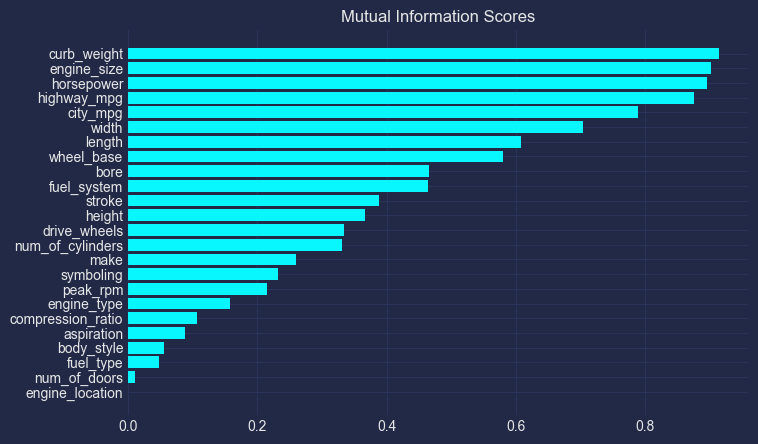

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

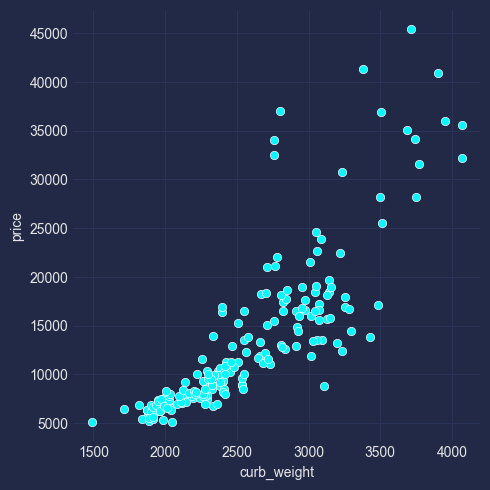

In [10]:
sns.relplot(x='curb_weight', y='price', data=data)  # , kind='line'

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

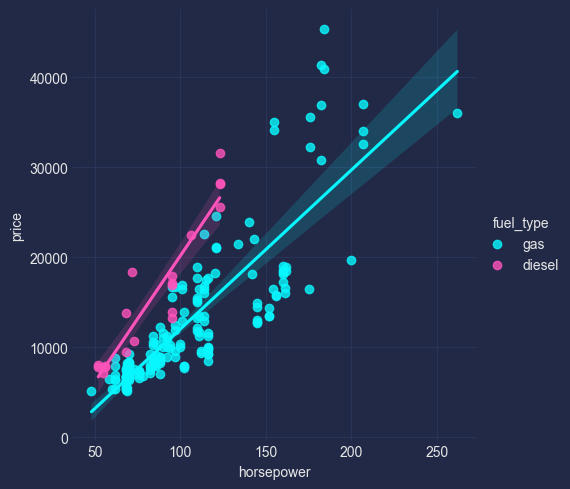

In [11]:
sns.lmplot(x='horsepower', y='price', hue='fuel_type', data=data)